The purpose of this notebook is to calculate the Spatial Access Indicator for Access to Banking in Chapter 7 of the PhD Thesis. I will be using two impedance functions which I construct on purpose for this analysis.

First function is reciprocal and the second is cummulative Gaussian (Vale, D. S., & Pereira, M. (2017). The influence of the impedance function on gravity-based pedestrian accessibility measures: A comparative analysis. Environment and Planning B: Urban Analytics and City Science, 44(4), 740–763. https://doi.org/10.1177/0265813516641685)

For both fuunctions I introduce a threshold theta_1 of 1500m for which the access is assumed to be perfect. We are interested in the very large distances.


In [1]:
from typing import Callable

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import mapclassify

from legendgram import legendgram 
import palettable.matplotlib as mplpal

import plotly.figure_factory as ff
import plotly.io as pio
import plotly.express as px #if using plotly

#from access import Access, weights, Datasets

## Data (sources)

Population Weighted Centroids 2021
https://geoportal.statistics.gov.uk/datasets/ons::llsoa-dec-2021-pwc-for-england-and-wales/explore

Population (Census 2021 - density)
https://www.nomisweb.co.uk/datasets/c2021ts006

Points of service (branches and post offices) - mextracted, cleaned, matched at point level as explaine din Chapter 4.

## I. Impedance function

The idea is to have a measure (an indicator) that can be used to qualify the access to a particular resource (in this case a branch or a post office) from a given area (in this case an Output Area). I calculate in QGIS the Euclidean distance between the resource and the (population weighted) centroid of the output area. This form an Origin-Destination Matrix whihc will be an input in the process of calculating the Access Indicator.
If later on, I calculate a real roal + mode Origin Destination Matrix, I can use it here.

I apply the following logic:

- for a distance between 0 and a certain threshold (ex. 1500m) the measure is constant and maximum
- beyond that first threshold and up to a second threshold the measure will decrease inverse related to the distance
- after the second threshold the measure will be 0
- at the second threshold the measure needs to be continuous
- the maximum value should be 1 for convenience

As I don't have a sensitivity analysis for whihc would indicate hiw this process behaves I try two functions whihc decrease inversely with the distance.

### a. (Step) Reciprocal Impedance Function

Here I normalise the ODMatrix using the step reciprocal function as below:

$$
f(d) = \begin{cases}
  1, & \text{if $d<\theta_1$}.\\
  \frac{k}{d}-c, & \text{if $\theta_1 \le d \le \theta_2$}. \\
  0, & \text{if $d>\theta_2$}.
\end{cases}
$$

with $\theta_1$ and $\theta_2$ the first and second thresholds and the two coefficients $k$ and $c$ chosen so that the function is continuous at the $\theta_1$ and the $\theta_2$ point. Thus:

$$
k = \frac{\theta_1\theta_2}{\theta_2-\theta_1} \\
\text{and} \\
c = \frac{\theta_1}{\theta_2-\theta_1}
$$

$\theta_1$, $\theta_2$ and $d$ must be expressed in the same unit of measures.

I create the function make_access_function with the thresholds theta_1 and theta_2.

In [2]:
def make_access_function(theta_1: float, theta_2: float) -> Callable:
    """Generator for access function.

    Parameters
    ----------
    theta_1 : float
        first threshold factor
    theta_2 : float
        second threshold factor

    Returns
    -------
    Callable
        function that calculates the access for a distance according to the
        thresholds supplied.
    """

    assert theta_2 > theta_1, "theta_2 should be larger than theta_1"
    k = theta_1 * theta_2 / (theta_2 - theta_1)
    c = theta_1 / (theta_2 - theta_1)
    
    def access_function(distance):
        if distance < theta_1:
            return 1
        if distance > theta_2:
            return 0
        return k / distance - c
    
    return access_function

### b) (Step) Cummulative Gaussian impedance function

Similarly as above I normalise the OD Matrix but using a different function called cummulative Gaussian by Vale et al. In their study on the impact of impedance function on gravity based accessibility measures they find that this function is the most appropriate for pedestrian mode of transportation. However, in my case, given that I use Euclidian distances, and the mode of transportation is not so important. 

For this function theta_1 has the same meaning. Theta_3 is used for calculating v. At theta_3 the function takes the value 0.5. I chose theta_3 value so it descends similarly to the reciprocal one.

In [3]:
def make_cumgauss_access_function(theta_1: float, theta_3: float) -> Callable:
    """Generator for access function for cumulative gaussian.

    Parameters
    ----------
    theta_1 : float
        first threshold factor (flat range)
    theta_2 : float
        second threshold factor (dacay to 0.5 of the function)

    Returns
    -------
    Callable
        function that calculates the access for a distance according to the
        thresholds supplied.
    """

    assert theta_3 > theta_1, "theta_2 should be larger than theta_1"
#     k = theta_1 * theta_2 / (theta_2 - theta_1)
#     c = theta_1 / (theta_2 - theta_1)
    v = - ((theta_3-theta_1)**2) / np.log(0.5)
    print(f'value of v={v}')
    
    def access_function(distance):
        if distance < theta_1:
            return 1
        return np.exp(- ((distance-theta_1)**2) / v)
    
    return access_function

## c) Example usage. Graph.

We will setup an access indicator function 

1) step reciprocal with $\theta_1$=500[meters] and $\theta_2$=5000[meters]. That means the points located closer than 500m will be rated as 1, those over 25000m  as 0 and those in between will follow an inverse decreasing function.

2) step cummulative Gaussian with $\theta_1$=500[meters] and $\theta_3$=3000[meters]

We will create the function and will display it on a graph.

value of v=3246063.842000168


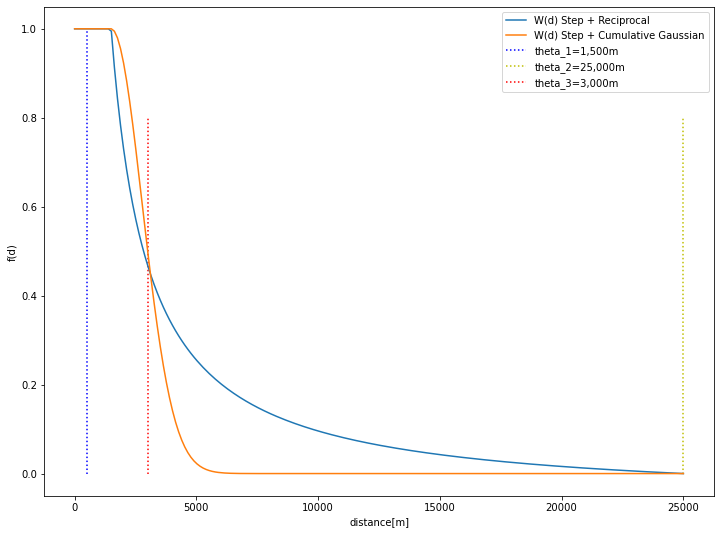

In [4]:
func = make_access_function(1500, 25000)
g_func = make_cumgauss_access_function(1500, 3000)

dist = np.linspace(0, 25000, 200)
indic = [func(d) for d in dist]
g_indic = [g_func(d) for d in dist]

plt.figure(figsize=(12,9))
plt.plot(dist, indic, label = 'W(d) Step + Reciprocal')
plt.vlines(500, 0, 1, linestyles='dotted', label='theta_1=1,500m', colors='b')
plt.vlines(25000, 0, 0.8, linestyles='dotted', label='theta_2=25,000m', colors='y')
plt.plot(dist, g_indic, label = 'W(d) Step + Cumulative Gaussian')
plt.vlines(3000, 0, 0.8, linestyles='dotted', label='theta_3=3,000m', colors='r')
plt.xlabel('distance[m]')
plt.ylabel('f(d)')
plt.legend()
plt.show()

In [5]:
plt.savefig(f'BR_Impedance_Functions_theta3_3000.png')

<Figure size 432x288 with 0 Axes>

## II. Building the dataframe OA/point of service/capacity/impedance function value(access)

The idea is to calculate the access indicator for each provider (branch) point and consumer OA. The result is stored in a table that include the OA of the provider and the OA of the consumer and will therefore summarize all access points in a provider OA in case they are several.

In the function calculate_access_matrix I build a dateframe with the following information:

    - OA21CD - the oputput area code of all the OAs in the region we are interested in. In Chapter 7 I run it for Wales but it could be run for England or the whole UK.
    - ID	 - this is the unique ID for each point (branch. post office). The ID is preserved across years for the points which remain open.
    - Distance	- This is the Euclidian Distance calculated in QGIS
    - ProviderOA - this is the OA of the branch (the provider of services). 	
    - Capacity	 - this is the opening time of the branch per week expressed in minutes
    - Access	 - this is the normalised value following the application of the impedance function to the OD matrix.

In [6]:
def calculate_access_matrix(br_df: gpd.GeoDataFrame, dist_df: pd.DataFrame, acc_func: Callable) -> pd.DataFrame:

    mat = pd.DataFrame()
    
    for _, branch in tqdm(br_df.iterrows(), total=len(br_df)):

        # get the available distances for the point of service (branch/post office)
        distances = dist_df[dist_df['InputID'] == branch.ID]
        # add ProviderOA which is the OA where the point of service is located
        distances.loc[:,'ProviderOA'] = branch.OA21CD
        distances.loc[:,'Capacity'] = branch.Time
        # calculate the access and access indicator for each point of service
        distances.loc[:,'Access'] = distances['Distance'].apply(acc_func)
        distances = distances[distances['Access'] != 0]     # remove 0s
#       distances = distances.merge(pop_df, how='left')
#       distances.loc[:,'AccessIndic'] = distances['Access'] * branch.Time
        # add to the return matrix
        mat = mat.append(distances)

    return mat

### a) Points of service (BR or PO)

##### minmax values for branches
    - 201907:18217.77
    - 202108:23196.96
    - 202207:24374.49
    - 202307:22338.00
        
    

Here I calculate the impedance function values for all periods, type of points and combination of type of points. for the thesis I calculated:
    - branches
    - post offices
    - branches and post offices
    - separately by brand for the largest four bansk in the UK + PO

In [7]:
access1500to3000 = make_cumgauss_access_function(1500, 3000)
# OAs = gpd.read_file('W_OA_PWC_27700')
datasets = [
#            '201907',
#            '202108',
#            '202207',
             '202307',
           ]

for dataset in datasets:
    
    #read the branch/points of service file
    branches = gpd.read_file(f'W_Branches_in_OA/WBR_{dataset}_OA_27700') 
    #read the OD Matrix (Euclidian distances)
    distances = pd.read_csv(f'DistanceMatrix_Branches/WBR_DM_{dataset}.csv') 
    #calculate the "access"/impedance fuunction values using the function created above
    access = calculate_access_matrix(branches, distances, access1500to3000) 
    #calculation level of service 
    access['Demand']= access['Access']/access.groupby('TargetID')['Access'].transform('sum')
    # save the calculation in a csv file. Pay attention to naming conventions
    # what impedance function you used (reciprocal or cumgaussian), what type of point (branch, post office), thresholds
    access.to_csv(f'CGauss_Access_{dataset}_BR_1500_3000.csv')

value of v=3246063.842000168


  0%|          | 0/357 [00:00<?, ?it/s]

In [8]:
access.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1235441 entries, 3500 to 3595549
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1235441 non-null  int64  
 1   TargetID    1235441 non-null  object 
 2   InputID     1235441 non-null  object 
 3   Distance    1235441 non-null  float64
 4   ProviderOA  1235441 non-null  object 
 5   Capacity    1235441 non-null  int64  
 6   Access      1235441 non-null  float64
 7   Demand      1235441 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 84.8+ MB


In [9]:
access.drop(['Unnamed: 0'], axis=1, inplace = True)

In [10]:
access.rename(columns = {'TargetID':'OA21CD', 'InputID':'ID'}, inplace = True)

### b) Population by OA

In [11]:
pop = gpd.read_file(f'W_OA_Pop_27700')

In [12]:
pop.drop(['OBJECTID', 'Shape__Are', 'Shape__Len','GlobalID', 'Pop_Dens', 'geometry'], axis=1, inplace = True)

In [13]:
pop.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10275 entries, 0 to 10274
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   OA21CD  10275 non-null  object 
 1   Pop     10275 non-null  float64
dtypes: float64(1), object(1)
memory usage: 160.7+ KB


In [14]:
access_p = access.merge(pop, how='left', on='OA21CD')

In [15]:
access_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1235441 entries, 0 to 1235440
Data columns (total 8 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   OA21CD      1235441 non-null  object 
 1   ID          1235441 non-null  object 
 2   Distance    1235441 non-null  float64
 3   ProviderOA  1235441 non-null  object 
 4   Capacity    1235441 non-null  int64  
 5   Access      1235441 non-null  float64
 6   Demand      1235441 non-null  float64
 7   Pop         1235441 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 84.8+ MB


## III. Calculate Demand (Step 3) and Level of Service (Step 4)

In [16]:
access_p['Dij'] = access_p['Demand'] * access_p['Pop']
access_p['CAij'] = access_p['Capacity']*access_p['Dij']/access_p.groupby('ID')['Dij'].transform('sum')

#access_p['L1ij'] = access_p['Dij'] / access_p['Capacity']

In [17]:
access_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1235441 entries, 0 to 1235440
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   OA21CD      1235441 non-null  object 
 1   ID          1235441 non-null  object 
 2   Distance    1235441 non-null  float64
 3   ProviderOA  1235441 non-null  object 
 4   Capacity    1235441 non-null  int64  
 5   Access      1235441 non-null  float64
 6   Demand      1235441 non-null  float64
 7   Pop         1235441 non-null  float64
 8   Dij         1235441 non-null  float64
 9   CAij        1235441 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 103.7+ MB


In [18]:
access_p.head()

,OA21CD,ID,Distance,ProviderOA,Capacity,Access,Demand,Pop,Dij,CAij
0,W00001194,NTW_0052,21372.278320,W00000927,15,1.461823e-53,1.955888e-53,293.012741,5.731001e-51,2.047671e-53
1,W00009980,NTW_0052,39482.343844,W00000927,15,9.663326e-194,9.663326e-194,209.944043,2.028758e-191,7.248694e-194
2,W00001054,NTW_0052,29080.777011,W00000927,15,1.679586e-102,5.604146e-103,244.914070,1.372534e-100,4.904026e-103
3,W00001145,NTW_0052,25299.170756,W00000927,15,1.662054e-76,5.536496e-77,211.961343,1.173523e-74,4.192965e-77
4,W00001699,NTW_0052,45271.261665,W00000927,15,4.639703e-257,6.628147e-258,286.957581,1.901997e-255,6.795782e-258


In [19]:
access_p.to_csv(f'Matrix_CG_WBR{datasets}_1500v3000_2406.csv')

In [20]:
access_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1235441 entries, 0 to 1235440
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   OA21CD      1235441 non-null  object 
 1   ID          1235441 non-null  object 
 2   Distance    1235441 non-null  float64
 3   ProviderOA  1235441 non-null  object 
 4   Capacity    1235441 non-null  int64  
 5   Access      1235441 non-null  float64
 6   Demand      1235441 non-null  float64
 7   Pop         1235441 non-null  float64
 8   Dij         1235441 non-null  float64
 9   CAij        1235441 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 103.7+ MB


## IV. Calculate Access Indicator by OA (Step 5)

In [21]:
AIOA = access_p.groupby(['OA21CD'])['CAij'].sum().reset_index()

In [22]:
AIOA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10274 entries, 0 to 10273
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   OA21CD  10274 non-null  object 
 1   CAij    10274 non-null  float64
dtypes: float64(1), object(1)
memory usage: 160.7+ KB


In [23]:
AIOA2 = AIOA.merge(pop, how='left', on='OA21CD')

In [24]:
AIOA2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10274 entries, 0 to 10273
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   OA21CD  10274 non-null  object 
 1   CAij    10274 non-null  float64
 2   Pop     10274 non-null  float64
dtypes: float64(2), object(1)
memory usage: 321.1+ KB


In [25]:
AIOA2['AIOAij']=AIOA2['CAij']/AIOA2['Pop']

In [26]:
AIOA2.to_csv(f'CG_WBRAIOA{dataset}_1500_3000_2406.csv')

In [27]:
AIOA2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10274 entries, 0 to 10273
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   OA21CD  10274 non-null  object 
 1   CAij    10274 non-null  float64
 2   Pop     10274 non-null  float64
 3   AIOAij  10274 non-null  float64
dtypes: float64(3), object(1)
memory usage: 401.3+ KB


## V. Maps

#### a) Bins

In [28]:
AIOA2['AIOAij'].describe()

count    10274.000000
mean         0.167844
std          0.130797
min          0.001494
25%          0.071349
50%          0.140872
75%          0.222957
max          0.673558
Name: AIOAij, dtype: float64

When making maps I explored a number of bins classifications. I opted for user defined bins so it shows in order to capture the ariety across the years visually. On needs to look at historgrams or KDE in order to see the distribution.

In [29]:
#quantiles
classi = mapclassify.Quantiles(AIOA2['AIOAij'], k=20)
classi

Quantiles           

  Interval     Count
--------------------
[0.00, 0.01] |   514
(0.01, 0.02] |   514
(0.02, 0.05] |   513
(0.05, 0.06] |   514
(0.06, 0.07] |   514
(0.07, 0.09] |   516
(0.09, 0.11] |   511
(0.11, 0.12] |   514
(0.12, 0.13] |   513
(0.13, 0.14] |   514
(0.14, 0.16] |   514
(0.16, 0.18] |   513
(0.18, 0.19] |   514
(0.19, 0.21] |   514
(0.21, 0.22] |   513
(0.22, 0.24] |   514
(0.24, 0.27] |   514
(0.27, 0.29] |   517
(0.29, 0.46] |   510
(0.46, 0.67] |   514

In [30]:
#user defined bins
bins = [0.11, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.36,0.46, 0.56, 0.66]
classi = mapclassify.UserDefined(AIOA2['AIOAij'], bins)
classi.bins.tolist()

[0.11,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.36,
 0.46,
 0.56,
 0.66,
 0.6735582137513956]

In [31]:
classi.bins

array([0.11      , 0.13      , 0.14      , 0.15      , 0.16      ,
       0.17      , 0.18      , 0.19      , 0.2       , 0.21      ,
       0.22      , 0.23      , 0.24      , 0.25      , 0.26      ,
       0.36      , 0.46      , 0.56      , 0.66      , 0.67355821])

### b) KDE distr + histo

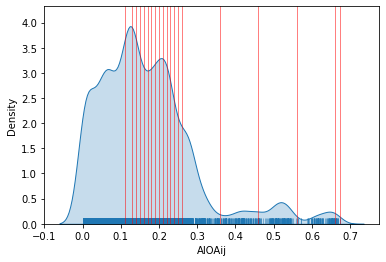

In [32]:
# Set up the figure
f, ax = plt.subplots(1)
# Plot the kernel density estimation (KDE)
sns.kdeplot(AIOA2['AIOAij'], shade=True)
# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(AIOA2['AIOAij'], alpha=0.5)
# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.5)
# Display image
plt.gcf()
#### change name
plt.savefig(f'WAIOABR{datasets}_KDE_UD20_CG1500_3000.png' , dpi=300)
plt.show()

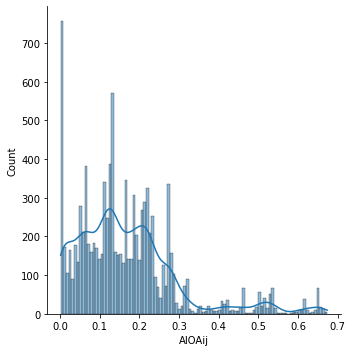

In [33]:
sns.displot(AIOA2['AIOAij'], bins=100, kde=True)

branches capacity for the respective month
2019 = 780520 min = 13008 h
2021 = 557255 min  = 9287 h
2022 = 558070 min = 9301 h
2023 = 522921 min = 8715 h 

### c) plot

The geometry for this map comes from the population shapefile I used above. I do not re-read it here.

In [34]:
W_Pop = gpd.read_file(f'W_OA_Pop_27700')

In [35]:
W_Pop.drop(['OBJECTID', 'Shape__Are', 'Shape__Len','GlobalID', 'Pop_Dens' ], axis=1, inplace = True)

In [36]:
Wales_Map = W_Pop.merge(AIOA2, on='OA21CD', how='left')

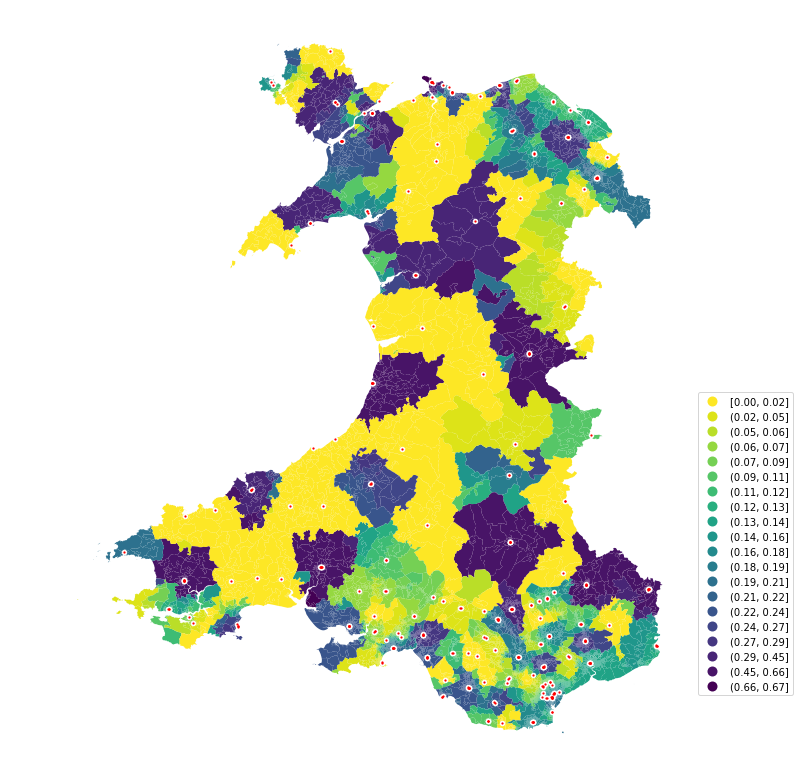

In [37]:
## Continuous
f, ax = plt.subplots(1, figsize=(14, 14))

Wales_Map.plot(column='AIOAij', 
              #scheme='Natural_Breaks', k=10,
              #scheme='quantiles', k=20,
              scheme = 'user_defined',
              classification_kwds={'bins':[0.02, 0.05, 0.06, 0.07, 0.09,0.11, 0.12,0.13,0.14,  0.16,0.18,0.19,0.21, 0.22, 0.24, 0.27, 0.29, 0.45,0.66]},  # this is the Q20 range for branches in 201907 CG
              #classification_kwds={'bins':[0.01, 0.03,0.07, 0.09, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.23, 0.26, 0.28, 0.32, 0.35, 0.36, 0.38, 0.45,0.64,0.90]},
              #classification_kwds={'bins':[0.01, 0.03, 0.09, 0.12, 0.15, 0.23, 0.26, 0.36, 0.45,0.90]},
              #classification_kwds={'bins':[0.08, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.26, 0.53, 0.73]},
              #classification_kwds={'bins':[0.36, 0.46, 0.56, 0.66, 0.76, 0.86, 0.96, 1.06, 1.31, 8.91]},
              legend=True,
              legend_kwds={'fmt': '{:.2f}', 'loc': 'upper left',  "bbox_to_anchor": (1, 0.5), "interval": True},
              ax=ax,
              cmap ='viridis_r',
              label = 'AIOAij', 
               markersize = 1,
              alpha =1)

# Plot it twice, so that the points' edgecolor does not hide other points' centers.
branches.plot(ax=ax, markersize=20, color='white')
branches.plot(ax=ax, markersize=5, color='red', edgecolor = "white", linewidth = 0)

#f.suptitle('Wales. Branches Access Indicator. July 2023')

#ax.legend(loc='upper left', frameon=False)
#ax.legend(frameon=False, loc='lower center', ncol=2)
ax.axis('off')
#leg = ax.legend()

#adds a title and axes labels
#ax.set_title('Distance vs Workout Duration')
#ax.set_xlab
#ax.set_ylabel('Workout Duration (min)')

Wales_Map_AI = plt.gcf()
plt.savefig(f'WAIOABR{datasets}_Map_UD20_CG15003000.png', dpi=300)
plt.show()